In [ ]:
#| default_exp methods.transforms

# Softmax

In [ ]:
#| export
import numpy as np
def _softmax(beta, x):
        """
        Given an input, calculates the normalized exponential function.
        """
        # rescale exponential to avoid large numbers
        rescale = max(x)
        exp_x = np.exp(beta *(x-rescale))
        # get normalization
        norm = sum(exp_x)
        # calculate normalized exponential
        softmax_x = exp_x/norm

        return softmax_x

# Logistic

In [ ]:
#| export
def _logistic(x, L:float = 1,k:float = 1,x_shift = 0,y_shift:float = 0):
    return L/(1 + np.exp(-k*(x-x_shift))) + y_shift

# Exponentiated Shift

In [ ]:
#| export
def _exponentiated_shift(x, k, epsilon = 0.0001):
    return (x + epsilon) ** (np.exp(-k)) / ((1 + 2*epsilon) ** (np.exp(-k)))

# Decay toward uniform

In [ ]:
#| export
import numpy as np
def _decay_toward_uniform(pmfs: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """
    Apply decay toward uniform distribution for each row of a batch of PMFs,
    with a potentially different alpha per column.

    Args:
        pmfs: Array of shape (K, N), where each column is a PMF summing to 1.
        alphas: Array of shape (N,), or scalar in shape (1,) or (), each alpha ∈ [0, 1].

    Returns:
        Array of shape (K, N), where each column is decayed toward uniform.
    """
    if pmfs.ndim == 1:
        pmfs = pmfs[np.newaxis,:]  # Convert to shape (1,K)

    if not np.allclose(pmfs.sum(axis=1), 1, atol=1e-9):
        raise ValueError("All rows in pmfs must sum to one")

    N = pmfs.shape[0]

    if np.isscalar(alphas) or alphas.shape == (1,):
        alphas = np.full((N,), float(alphas))
    
    if not np.all((0 <= alphas) & (alphas <= 1)):
        raise ValueError("All alphas must be between 0 and 1")

    K = pmfs.shape[1]
    uniform = np.full((N, K), 1 / K)
    alphas = alphas[:,np.newaxis]  # Ensure broadcasting over rows
    new_pmfs = (1 - alphas) * pmfs + alphas * uniform
    return new_pmfs

## Example

Two probability mass functions decay toward a uniform probability mass function at a rate of 0.1 over 50 time steps

In [ ]:
import matplotlib.pyplot as plt

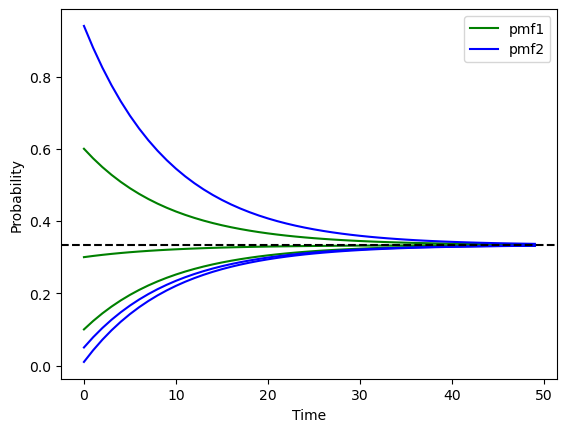

In [ ]:
probability_mass_function1 = np.array((0.1,0.3,0.6))
probability_mass_function2 = np.array((0.01,0.05,0.94))
pmfs = np.row_stack((probability_mass_function1,probability_mass_function2))
time_steps = 50
decay_rate = 0.1
pmfs_time_evolution = np.zeros((time_steps, *pmfs.shape)) #* unpacks the shape tuple

for t in range(time_steps):
    pmfs_time_evolution[t,:,:] = pmfs
    pmfs = _decay_toward_uniform(pmfs, decay_rate)

for i in range(np.shape(pmfs)[0]):
    for j in range(np.shape(pmfs)[1]):
        label = ['pmf1', 'pmf2'][i] if j == 0 else None  # Add label only once per pmf
        plt.plot(range(time_steps), pmfs_time_evolution[:,i,j], color = ["green","blue"][i], label = label)
plt.axhline(y = 1/3, linestyle = '--', color = 'black')
plt.xlabel('Time')
plt.ylabel('Probability')
legend = plt.legend()

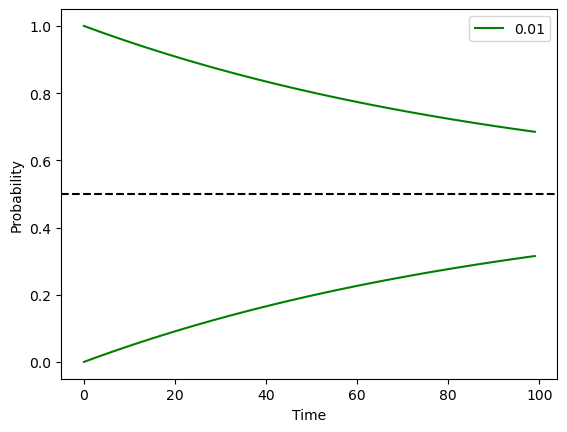

In [ ]:
pmf = np.array((0,1))
pmf = pmf[np.newaxis,:]
time_steps = 100
decay_rate = 0.01
pmf_time_evolution = np.zeros((time_steps, *pmf.shape)) #* unpacks the shape tuple

for t in range(time_steps):
    pmf_time_evolution[t,:,:] = pmf
    pmf = _decay_toward_uniform(pmf, decay_rate)

for i in range(np.shape(pmf)[0]):
    for j in range(np.shape(pmf)[1]):
        label = decay_rate if j == 0 else None  # Add label only once per decay rate
        plt.plot(range(time_steps), pmf_time_evolution[:,i,j], color = 'green', label = label)
plt.axhline(y = 1/2, linestyle = '--', color = 'black')
plt.xlabel('Time')
plt.ylabel('Probability')
legend = plt.legend()

## Logit Bias

In [ ]:
#| export
def _logit_bias(rate, bias):
    if isinstance(rate, np.ndarray):
        assert np.issubdtype(rate.dtype, np.floating)
    else:
        assert isinstance(rate, (float, np.floating))
        rate = np.array(rate)
    if np.any(rate < 0) or np.any(rate > 1):
        raise ValueError("rate in logit_bias transformation must be between 0 and 1")
    if isinstance(bias, np.ndarray):
        assert np.issubdtype(bias.dtype, np.floating)
    else:
        assert isinstance(bias, (int, float, np.floating, np.integer))
        bias = np.array(bias)
        
    #broadcast if either rate or bias given as scalar
    if rate.size == 1:
        rate = np.full_like(bias, rate.item())
    elif bias.size == 1:
        bias = np.full_like(rate, bias.item())
    # Check if arrays can be compared element-wise
    if rate.shape != bias.shape:
        raise ValueError(f"Array shapes do not match: {rate.shape} vs {bias.shape}")

    #set up mask for 0 and 1 edge cases
    mask = (rate == 0) | (rate == 1)
    new_rate = rate.copy() #intialize new variable for transform
    new_rate[~mask] = np.log2(rate[~mask]/(1-rate[~mask])) + bias[~mask] #add bias in logit space
    new_rate[~mask] = 1/(1 + 2**-new_rate[~mask]) #reverse sigmoid
    return new_rate    

In [ ]:
_logit_bias(np.array((0.,0.5,1.)), np.array((-1,0,1))[1])

### Example

In [ ]:
rate_values = np.linspace(0, 1, 100)
bias_values = np.array((-3,-1,0,1,3))

for bias in bias_values:
    biased_rates = _logit_bias(rate_values, bias)
    plt.plot(rate_values, biased_rates, label = "bias = " + str(bias))
plt.title('logit bias function')
plt.xlabel('rate')
plt.ylabel('biased rate')
plt.legend();